In [1]:
from IPython import display
import os
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
import seaborn as sns
import time
import random
from torchvision.models import resnet18

In [2]:
colab = False
if colab:
    chemin = "/content/drive/Othercomputers/My laptop/Documents/Master ISN/M2/Projet_fevr/Projet1/Données"
else : 
    chemin = os.getcwd()+"/Données"

### Fonction pivotage photos

In [3]:
def resize_and_rotate(x, angle=0):
    '''
    redimentionne les images + exécute une rotation de "angle" degrés
    '''
    trans = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomRotation(angle)])
    return trans(x)


def expansion_img(tensor, nb_angles):
    '''
    Pivote les photos et les ajoutent à la fin du tensor
    '''
    angles = np.linspace(0, 360, num=nb_angles+1)
    angles = angles[:-1]
    new_tensor = torch.zeros((tensor.shape[0] * nb_angles, tensor.shape[1], tensor.shape[2], tensor.shape[3]))
    for i in range(tensor.shape[0]):
        for j, angle in enumerate(angles):
            new_tensor[i*nb_angles + j] = resize_and_rotate(tensor[i], angle)
    return new_tensor


def labels_increase(tensor, nb_angles):
    '''
    adapte la taille du tensor labels 
    '''
    new_tensor = torch.zeros(tensor.shape[0] * nb_angles, dtype=torch.long)
    for i in range(tensor.shape[0]):
        for j in range(nb_angles):
            new_tensor[i*nb_angles + j] = tensor[i]
    return new_tensor

### Importation des données

In [4]:
typeFleur =  [species for species in os.listdir(chemin) if os.path.isdir(f"{chemin}/{species}")]
Names={}
nb=0
for type_ in typeFleur:
    filenames = [name for name in os.listdir(f"{chemin}/{type_}") if os.path.splitext(name)[-1] == '.jpg']
    nb+=len(filenames)
    Names[type_]=filenames

batch = torch.zeros(nb, 3, 224, 224, dtype=torch.float32)
labels=np.empty(nb, dtype="U20")

i=-1
for espece, list_img in Names.items():
    for name in list_img:
        path = f"{chemin}/{espece}/{name}"
        i+=1 
        print(f"{i+1}/{nb}")
        display.clear_output(wait=True)
        img = resize_and_rotate(torchvision.io.read_image(path), 0)/255.0
        batch[i] = img
        labels[i]=espece

y = torch.as_tensor(preprocessing.LabelEncoder().fit_transform(labels))  # labels en chiffres
X = batch

1360/1360


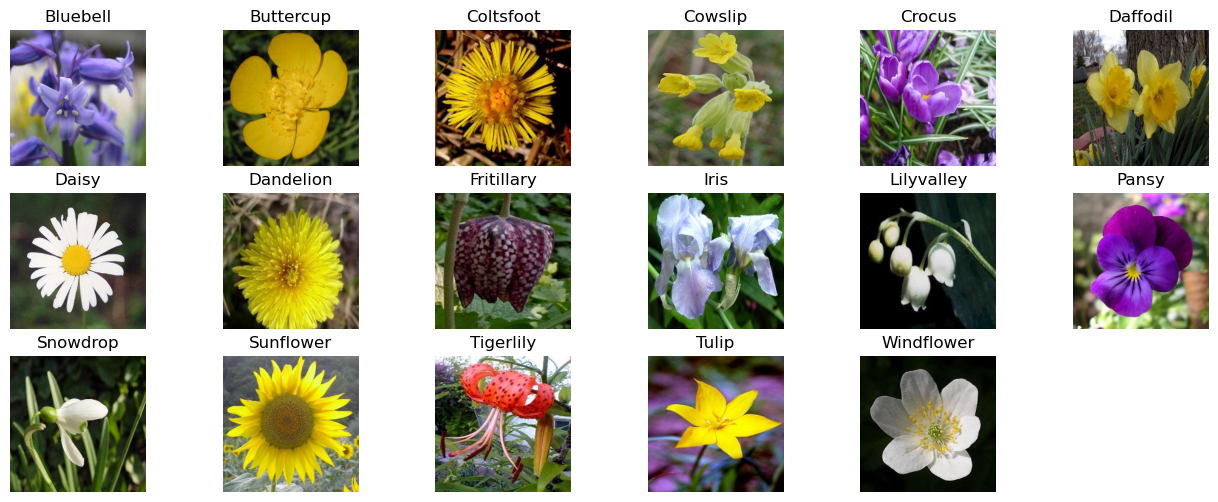

In [5]:
# show some images
plt.figure(figsize=(16, 6))
for i in range(17):
    plt.subplot(3, 6, i+1)
    image = X[i*80]
    plt.title(typeFleur[i])
    plt.imshow(np.transpose(image, (1,2,0)))  # image.shape ==> (dim(RGB)=3, longueur, largeur)
    plt.axis('off');                          # plt.imshow nécessite (longueur, largeur, dim(RGB)=3)

In [5]:
start_time = time.time()

increase = 4   # on augmente la taille du jeu de données d'un facteur increase
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = expansion_img(X_train, increase)   # on augmente la taille uniquement de l'échant train
y_train = labels_increase(y_train, increase)

end_time = time.time()

In [7]:
print(f"Durée de transformation : {int((end_time - start_time)//60)} minutes et {int((end_time - start_time)%60)} secondes")

Durée de transformation : 0 minutes et 38 secondes


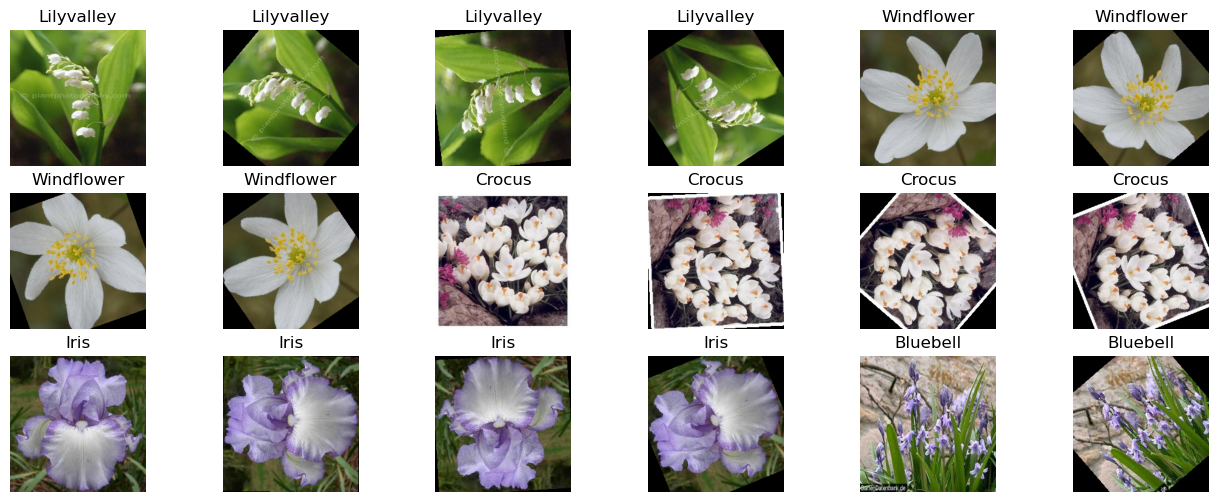

In [8]:
# show some images
plt.figure(figsize=(16, 6))
for i in range(18):
    plt.subplot(3, 6, i+1)
    image = X_train[i]
    plt.title(typeFleur[int(y_train[i])])
    plt.imshow(np.transpose(image, (1,2,0)))  # image.shape ==> (dim(RGB)=3, longueur, largeur)
    plt.axis('off'); 

In [6]:
batch_size = 4 

train_dataset = data.TensorDataset(X_train, y_train)
test_dataset = data.TensorDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=True)



In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
model = resnet18(weights=None).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [11]:
num_epochs = 10
n_total_steps = len(train_loader)
accur = [0 for i in range(num_epochs)]
start_time = time.time()

ESPECE = []
PREDICTION = []

for epoch in range(num_epochs):
    train_acc = 0
    n_samples = 0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        model.train()
        # Forward pass
        outputs = model(images)  #shape :  batch_size, 17
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        display.clear_output(wait=True)
        print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
    
    
    with torch.no_grad():
        prediction = []
        espece = []
        n_correct = 0
        n_samples = 0
        model.eval()
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images) 
            _, predicted = torch.max(outputs, 1)
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()

            for i in range(batch_size):
                label = labels[i]
                pred = predicted[i]
                espece.append(label)
                prediction.append(pred)
            ESPECE.append(espece)
            PREDICTION.append(prediction)

        acc = 100.0 * n_correct / n_samples
        accur.append(acc)
    
print(f'Finished Training')
end_time = time.time()


Epoch [10/10], Step [1088/1088], Loss: 0.3723
Finished Training


In [14]:
print(f"Durée d'exécution : {int((end_time - start_time)//60)} minutes et {int((end_time - start_time)%60)} secondes")

Durée d'exécution : 249 minutes et 24 secondes


In [15]:
with torch.no_grad():
    prediction = []
    espece = []
    n_correct = 0
    n_samples = 0
    
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images) 
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        
        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            espece.append(label)
            prediction.append(pred)
        
    acc = 100.0 * n_correct / n_samples
    print(f'Train Accuracy of the network: {acc} %')

Train Accuracy of the network: 90.90073529411765 %


In [16]:
with torch.no_grad():
    prediction = []
    espece = []
    n_correct = 0
    n_samples = 0
    
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images) 
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        
        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            espece.append(label)
            prediction.append(pred)
        
    acc = 100.0 * n_correct / n_samples
    print(f'Test Accuracy of the network: {acc} %')


Test Accuracy of the network: 76.83823529411765 %


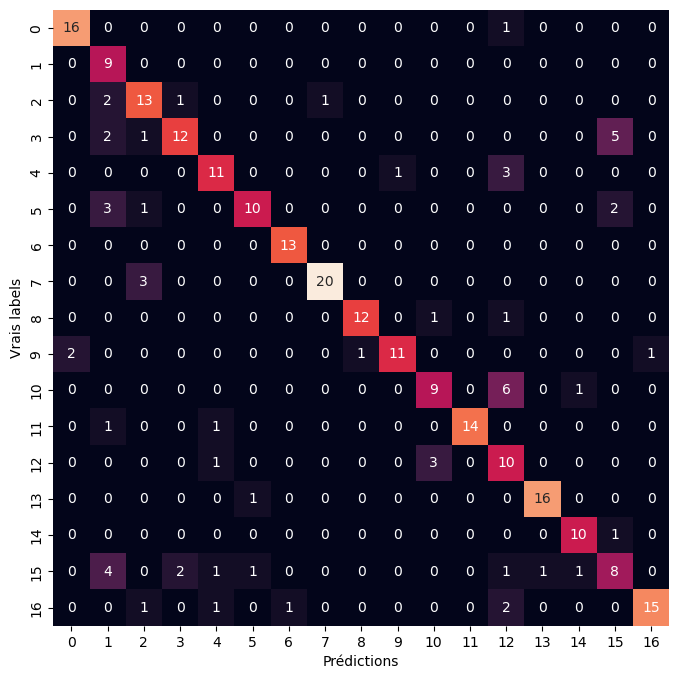

In [17]:
confusionX=confusion_matrix(espece,prediction)

plt.figure(figsize=(8,8))  # set plot size (denoted in inches)
sns.heatmap(confusionX,square=True, fmt='d', cbar=False ,annot=True)

plt.xlabel("Prédictions")
plt.ylabel("Vrais labels")
plt.show()

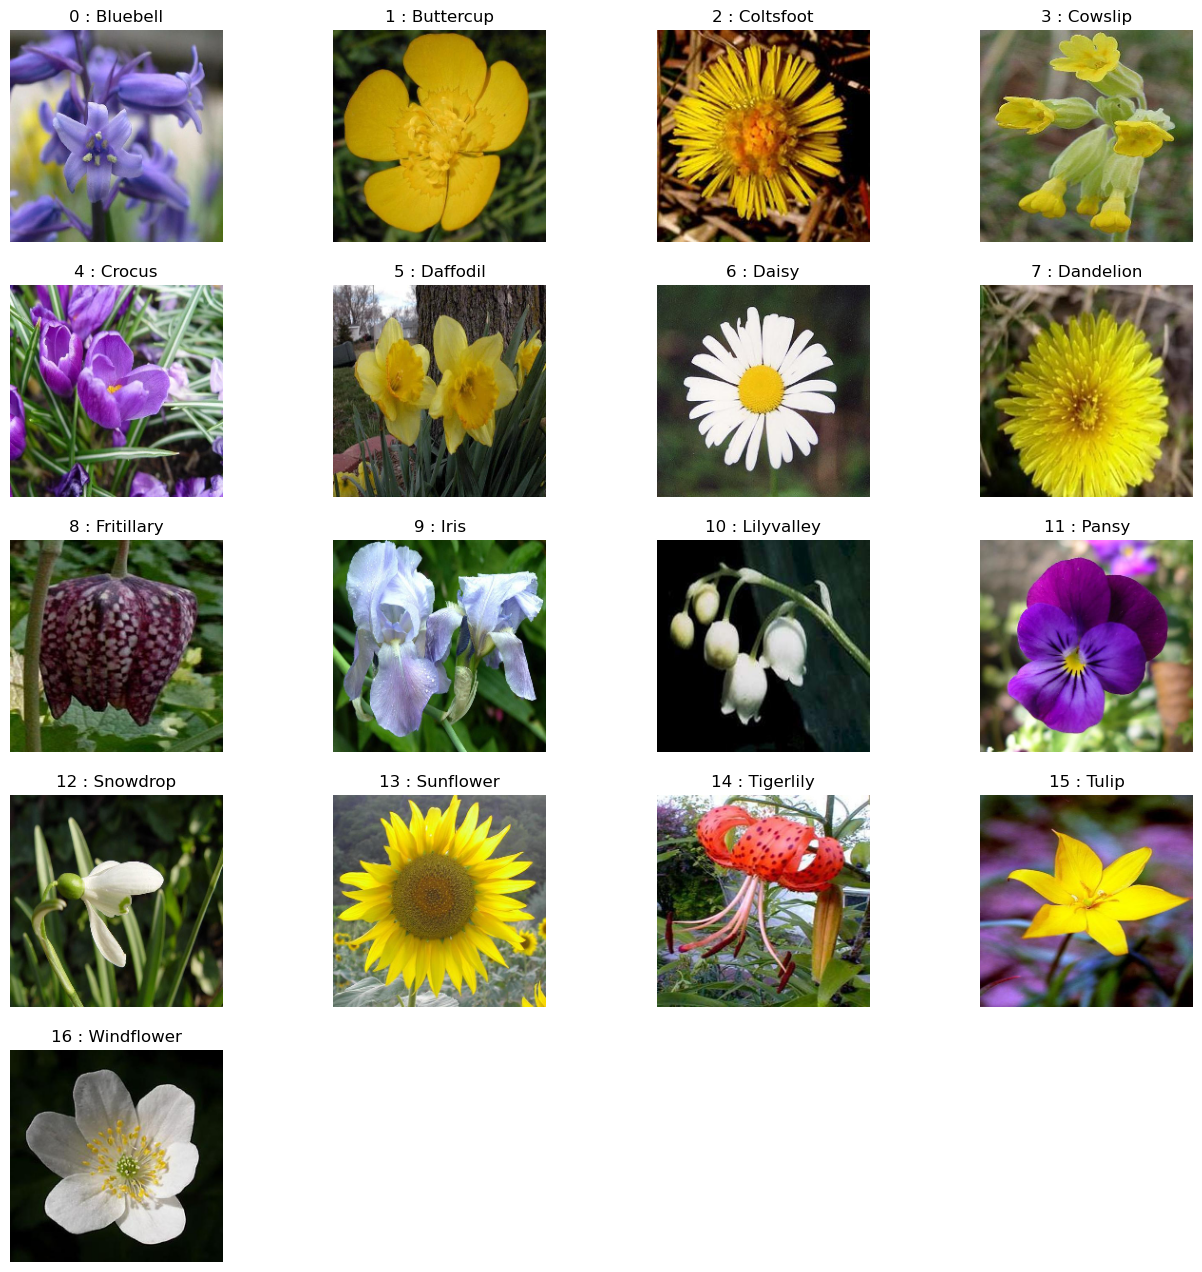

In [18]:
# show some images
plt.figure(figsize=(16, 16))
for i in range(17):
    img = (80*i)
    plt.subplot(5, 4, i+1)
    image = X[img]
    plt.title(f"{i} : {typeFleur[i]}")
    plt.imshow(np.transpose(image, (1,2,0)))  # image.shape ==> (dim(RGB)=3, longueur, largeur)
    plt.axis('off'); 